# Importing Libraries & Dataset

In [ ]:
import pandas as pd
import numpy as np
import zipfile
from google.colab import drive

import missingno as msno
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

from nltk.corpus import stopwords
from collections import Iterable, defaultdict, Counter
from wordcloud import WordCloud, STOPWORDS
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  del sys.path[0]


True

In [ ]:
# Unzipping files from drive
drive.mount('/content/drive/', force_remount=True)
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/NLP_Project/Dataset.zip', 'r')
zip_ref.extractall('/data_tmp')
zip_ref.close()

Mounted at /content/drive/


# Exploring the data

## Splitting Development and Testing data
- Since we want to see how our model perform, we will split our dataset. However, the dataset provided by Kaggle already divide it into two parts, Train and Test. Train data will be used for EDA purposes and test data will be used as `unseen` data for our `predict` function.

In [ ]:
data_train = pd.read_csv('/data_tmp/Dataset/Corona_NLP_train.csv', encoding='latin-1')
data_test = pd.read_csv('/data_tmp/Dataset/Corona_NLP_test.csv', encoding='latin-1')

In [ ]:
data_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
data_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
print(f'Train data contains {data_train.shape[0]} rows and {data_train.shape[1]} columns')
print(f'Test data contains {data_test.shape[0]} rows and {data_test.shape[1]} columns')

Train data contains 41157 rows and 6 columns
Test data contains 3798 rows and 6 columns


## Missing Values

In [ ]:
data_train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

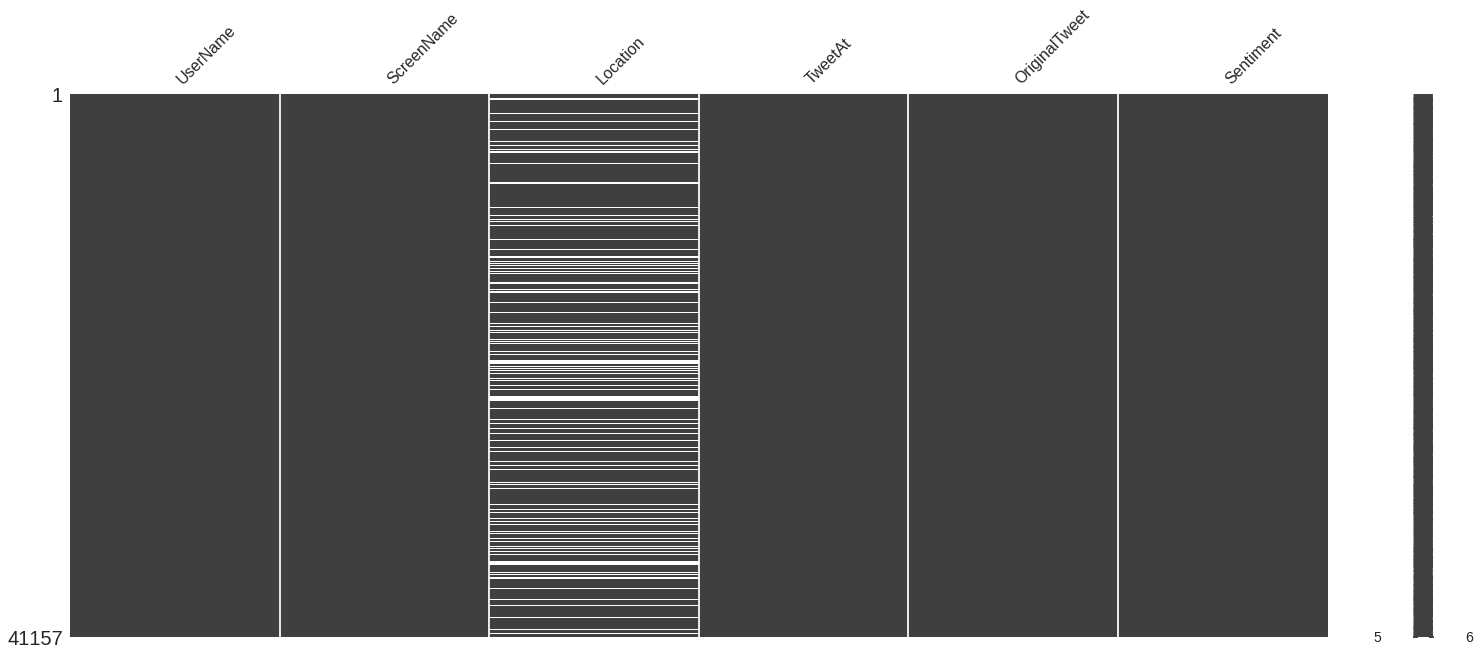

<Figure size 720x576 with 0 Axes>

In [ ]:
msno.matrix(data_train)
plt.figure(figsize=(10,8))
plt.show()

- Missing data visualized by given white lines which basically on "Location" Column.

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


> As we can see, TweetAt basically a datetime data, so we need to convert it to datetime type for our analysis.

In [ ]:
data_train['TweetAt'] = pd.to_datetime(data_train['TweetAt'])
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


## Duplicated tweets

In [ ]:
if data_train.duplicated() is True:
  print('There are duplicated data')
else:
  print("There isn't any duplicated data")

There isn't any duplicated data


- Since there isn't any duplicated data, we don't need to handle this problem.

## Tweets Counts

### Based on Location

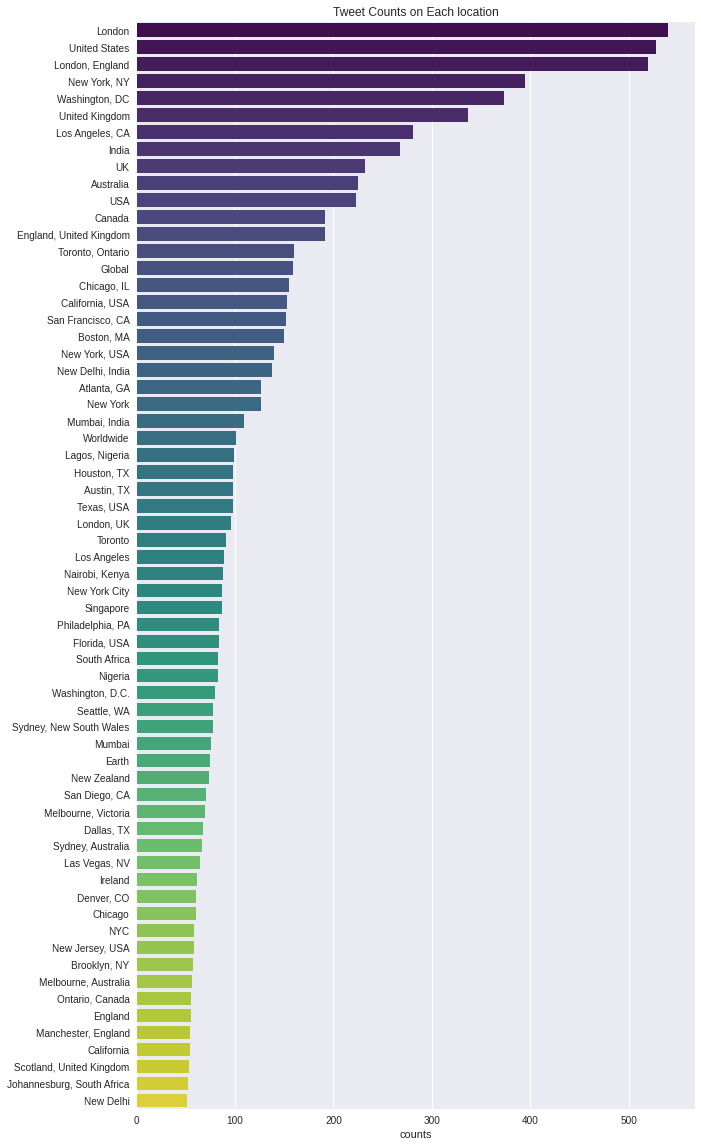

In [ ]:
tweets_on_location = data_train['Location'].value_counts().loc[lambda x : x > 50].reset_index(name='counts')

plt.figure(figsize=(10,20))
sns.barplot(x='counts', y='index', data = tweets_on_location, label='Counts', color='b', palette='viridis')
plt.title('Tweet Counts on Each location')
plt.ylabel('')
plt.show()

### Based on Date

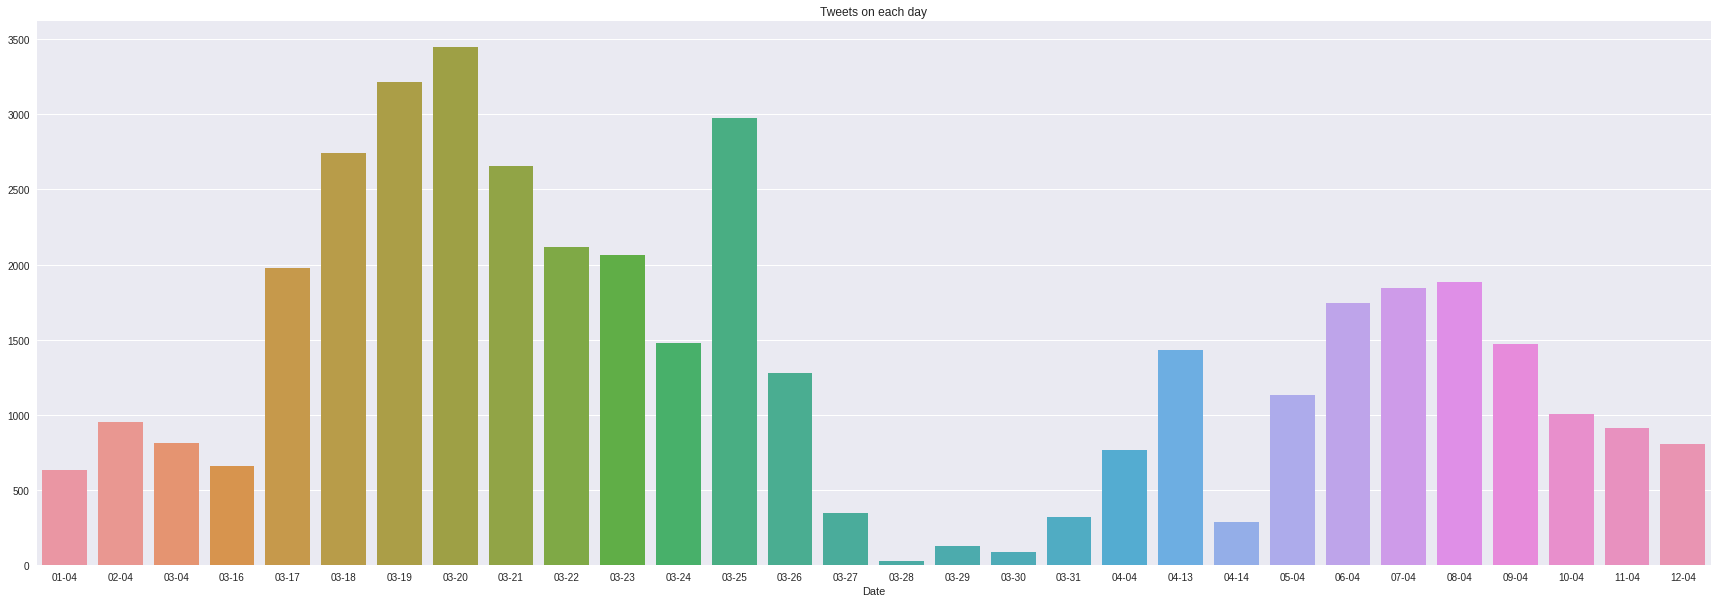

In [ ]:
tweets_date = data_train['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

plt.figure(figsize=(30,10))
sns.barplot(x='index',y='counts', data=tweets_date)
plt.title('Tweets on each day')
plt.xlabel('Date')
plt.ylabel('')
plt.show()

## Sentiment Class Distribution

- This data actually have 5 sentiment classes, Extremely Positive, Positive, Neutral, Negative, and Extremely Negative. In this case, we will try to combine Extremely Positive with Positive, and Extremely Negative with Negative.

In [ ]:
def class_disb(x):
  if x == 'Extremely Positive':
    return 'Positive'
  elif x == 'Positive':
    return 'Positive'
  elif x == 'Extremely Negative':
    return 'Negative'
  elif x == 'Negative':
    return 'Negative'
  else:
    return 'Neutral'

data_train['Sentiment'] = data_train['Sentiment'].apply(lambda x : class_disb(x))
data_test['Sentiment'] = data_test['Sentiment'].apply(lambda x : class_disb(x))

In [ ]:
data_train['text'] = data_train['OriginalTweet'].astype(str)
class_sentiment_train = data_train.groupby('Sentiment').count()['text'].reset_index().sort_values(by='text', ascending=False)
class_sentiment_train.style.background_gradient()

,Sentiment,text
2,Positive,18046
0,Negative,15398
1,Neutral,7713


In [ ]:
data_test['text'] = data_test['OriginalTweet'].astype(str)
class_sentiment_test = data_test.groupby('Sentiment').count()['text'].reset_index().sort_values(by='text', ascending=False)
class_sentiment_test.style.background_gradient()

,Sentiment,text
0,Negative,1633
2,Positive,1546
1,Neutral,619


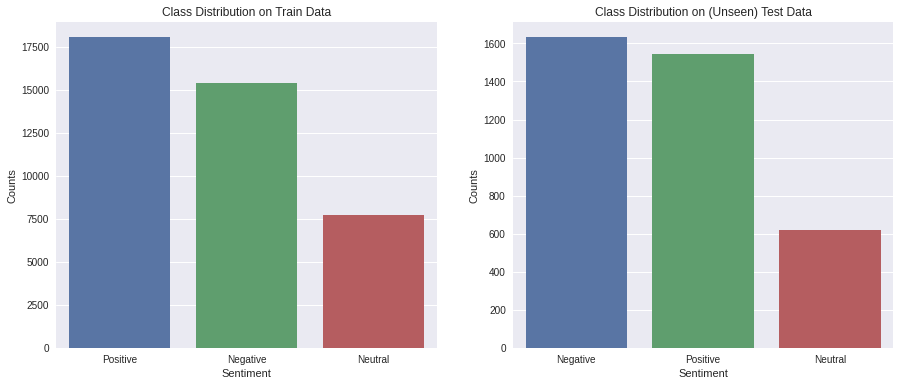

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

sns.barplot(x='Sentiment', y='text',ax=ax[0], data=class_sentiment_train)
ax[0].set_title('Class Distribution on Train Data')
ax[0].set_ylabel('Counts')

sns.barplot(x='Sentiment', y='text',ax=ax[1], data=class_sentiment_test)
ax[1].set_title('Class Distribution on (Unseen) Test Data')
ax[1].set_ylabel('Counts')

plt.show()

- Both train and test (Unseen) data seems to be imbalanced. We need to handled it soon to improve our model's performance.

## Word Counts in Tweets

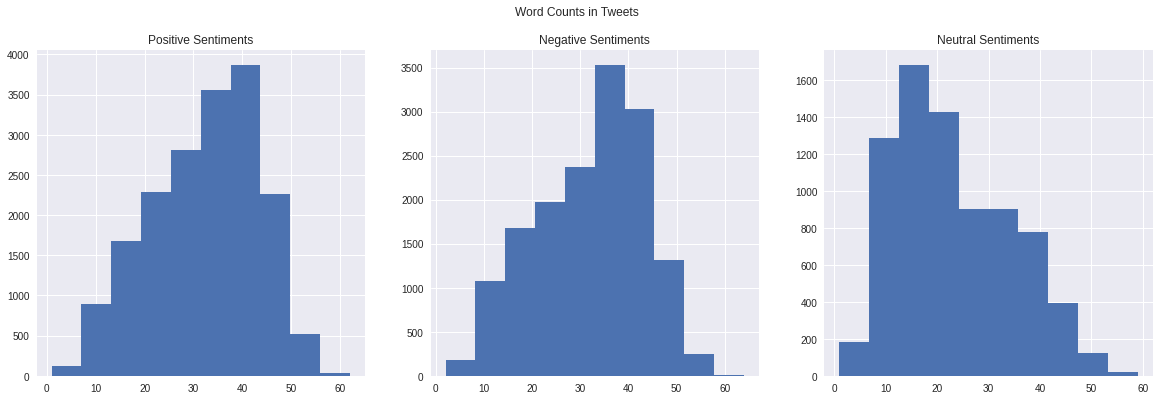

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))

positive_tweets = data_train[data_train['Sentiment'] == 'Positive']['text'].str.split().map(lambda x: len(x))
ax1.hist(positive_tweets)
ax1.set_title('Positive Sentiments')

negative_tweets = data_train[data_train['Sentiment'] == 'Negative']['text'].str.split().map(lambda x: len(x))
ax2.hist(negative_tweets)
ax2.set_title('Negative Sentiments')

neutral_tweets = data_train[data_train['Sentiment'] == 'Neutral']['text'].str.split().map(lambda x: len(x))
ax3.hist(neutral_tweets)
ax3.set_title('Neutral Sentiments')

plt.suptitle('Word Counts in Tweets')
plt.show()

- The distribution of words in each sentiment is normalized enough.

## Average number of words in each Tweet

In [ ]:
lengths = data_train['text'].str.split().apply(lambda x: len(x))
print(lengths.describe())

count    41157.000000
mean        30.500304
std         11.591172
min          1.000000
25%         21.000000
50%         32.000000
75%         40.000000
max         64.000000
Name: text, dtype: float64


- We can see that average word length in train data is 30 words.

In [ ]:
lengt = data_train['text'].loc[data_train['Sentiment'] == 'Positive'].str.split().apply(lambda x: len(x))
print(lengt.describe())

count    18046.000000
mean        32.362740
std         10.831779
min          1.000000
25%         24.000000
50%         34.000000
75%         41.000000
max         62.000000
Name: text, dtype: float64


- We can also see that average word length in "Positive" sentiment based word is 32 words.

In [ ]:
lengt = data_train['text'].loc[data_train['Sentiment'] == 'Negative'].str.split().apply(lambda x: len(x))
print(lengt.describe())

count    15398.000000
mean        32.005195
std         11.189087
min          2.000000
25%         24.000000
50%         34.000000
75%         41.000000
max         64.000000
Name: text, dtype: float64


- We can also see that average word length in "Negative" sentiment based word is 32 words.

In [ ]:
lengt = data_train['text'].loc[data_train['Sentiment'] == 'Neutral'].str.split().apply(lambda x: len(x))
print(lengt.describe())

count    7713.000000
mean       23.138468
std        11.210616
min         1.000000
25%        14.000000
50%        21.000000
75%        31.000000
max        59.000000
Name: text, dtype: float64


- We can also see that average word length in "Neutral" sentiment based word is 23 words.

## Common Words on Tweets

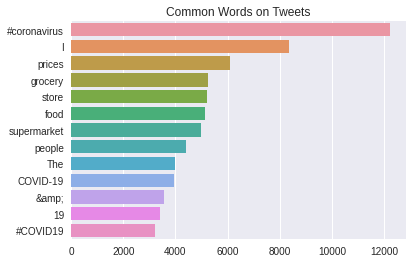

In [ ]:
corpus = []
for x in data_train['text'].str.split():
  for i in x:
    corpus.append(i)

stop_w = stopwords.words('english')
ctr = Counter(corpus).most_common()
x = []
y = []
for w, c in ctr[:50]:
  if (w not in stop_w):
    x.append(w)
    y.append(c)

sns.barplot(x=y, y=x)
plt.title('Common Words on Tweets')
plt.show()

- As we can see above, there are still words that contains punctuations, this needs to handled.

## WordCloud
- WordCloud can help us to visualize words frequency especially in each sentiment classes.

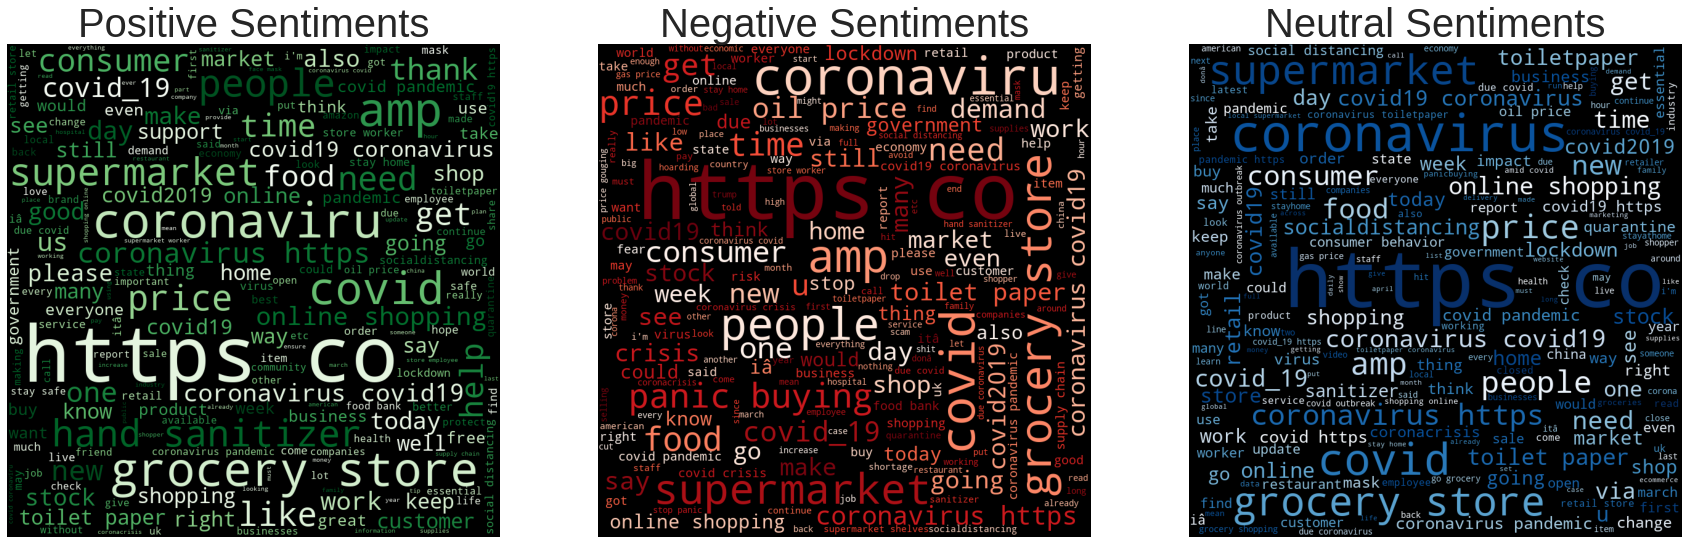

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(30,15))

data_pos = data_train[data_train['Sentiment'] == 'Positive']
data_neg = data_train[data_train['Sentiment'] == 'Negative']
data_net = data_train[data_train['Sentiment'] == 'Neutral']
stop_w = stopwords.words('english')

words = ''

for v in data_pos['text']:
  tokens = str(v).split()
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
  words += ' '.join(tokens)+' '

wc_pos = WordCloud(width=800, height=800,background_color = 'black',
                   colormap='Greens',
                   stopwords=stop_w,
                   min_font_size=10).generate(words)

ax[0].imshow(wc_pos)
ax[0].axis('off')
ax[0].set_title("Positive Sentiments", fontsize=40)

words = ''

for v in data_neg['text']:
  tokens = str(v).split()
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
  words += ' '.join(tokens)+' '

wc_neg = WordCloud(width=800, height=800,background_color = 'black',
                   colormap='Reds',
                   stopwords=stop_w,
                   min_font_size=10).generate(words)

ax[1].imshow(wc_neg)
ax[1].axis('off')
ax[1].set_title("Negative Sentiments", fontsize=40)

words = ''

for v in data_net['text']:
  tokens = str(v).split()
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
  words += ' '.join(tokens)+' '

wc_net = WordCloud(width=800, height=800,background_color = 'black',
                   colormap='Blues',
                   stopwords=stop_w,
                   min_font_size=10).generate(words)

ax[2].imshow(wc_net)
ax[2].axis('off')
ax[2].set_title("Neutral Sentiments", fontsize=40)

plt.show()

- In all of three classes, we can see that URL links frequently exists in each tweets. We need to handle it so it won't decrease our model's performance.

## N-Gram
- N-gram can help us to find out sequence of text based on how it being speeched. In this case, we want to visualize unigram, bi-gram, and tri-gram based on each sentiment classes.

In [ ]:
# Function
def n_gram(text, n_gram=1):
  tokens = [t for t in text.lower().split(' ') if t != '' if t not in stop_w]
  ngram = zip(*[tokens[i:] for i in range(n_gram)])
  return [' '.join(n_gr) for n_gr in ngram]

In [ ]:
# Initialize top words (N)
N = 20

# Assign tweet to each class
pos = data_train['Sentiment'] == 'Positive'
neg = data_train['Sentiment'] == 'Negative'
net = data_train['Sentiment'] == 'Neutral'

### Unigram

In [ ]:
# Assign an empty dictionary
pos_uni = defaultdict(int)
neg_uni = defaultdict(int)
net_uni = defaultdict(int)

In [ ]:
# Positive Unigram
for t in data_train[pos]['text']:
  for w in n_gram(t):
    pos_uni[w] += 1

# Negative Unigram
for t in data_train[neg]['text']:
  for w in n_gram(t):
    neg_uni[w] += 1

# Neutral Unigram
for t in data_train[net]['text']:
  for w in n_gram(t):
    net_uni[w] += 1

# Creating Dataframes
df_pos_uni = pd.DataFrame(sorted(pos_uni.items(), key=lambda x: x[1])[::-1])
df_neg_uni = pd.DataFrame(sorted(neg_uni.items(), key=lambda x: x[1])[::-1])
df_net_uni = pd.DataFrame(sorted(net_uni.items(), key=lambda x: x[1])[::-1])

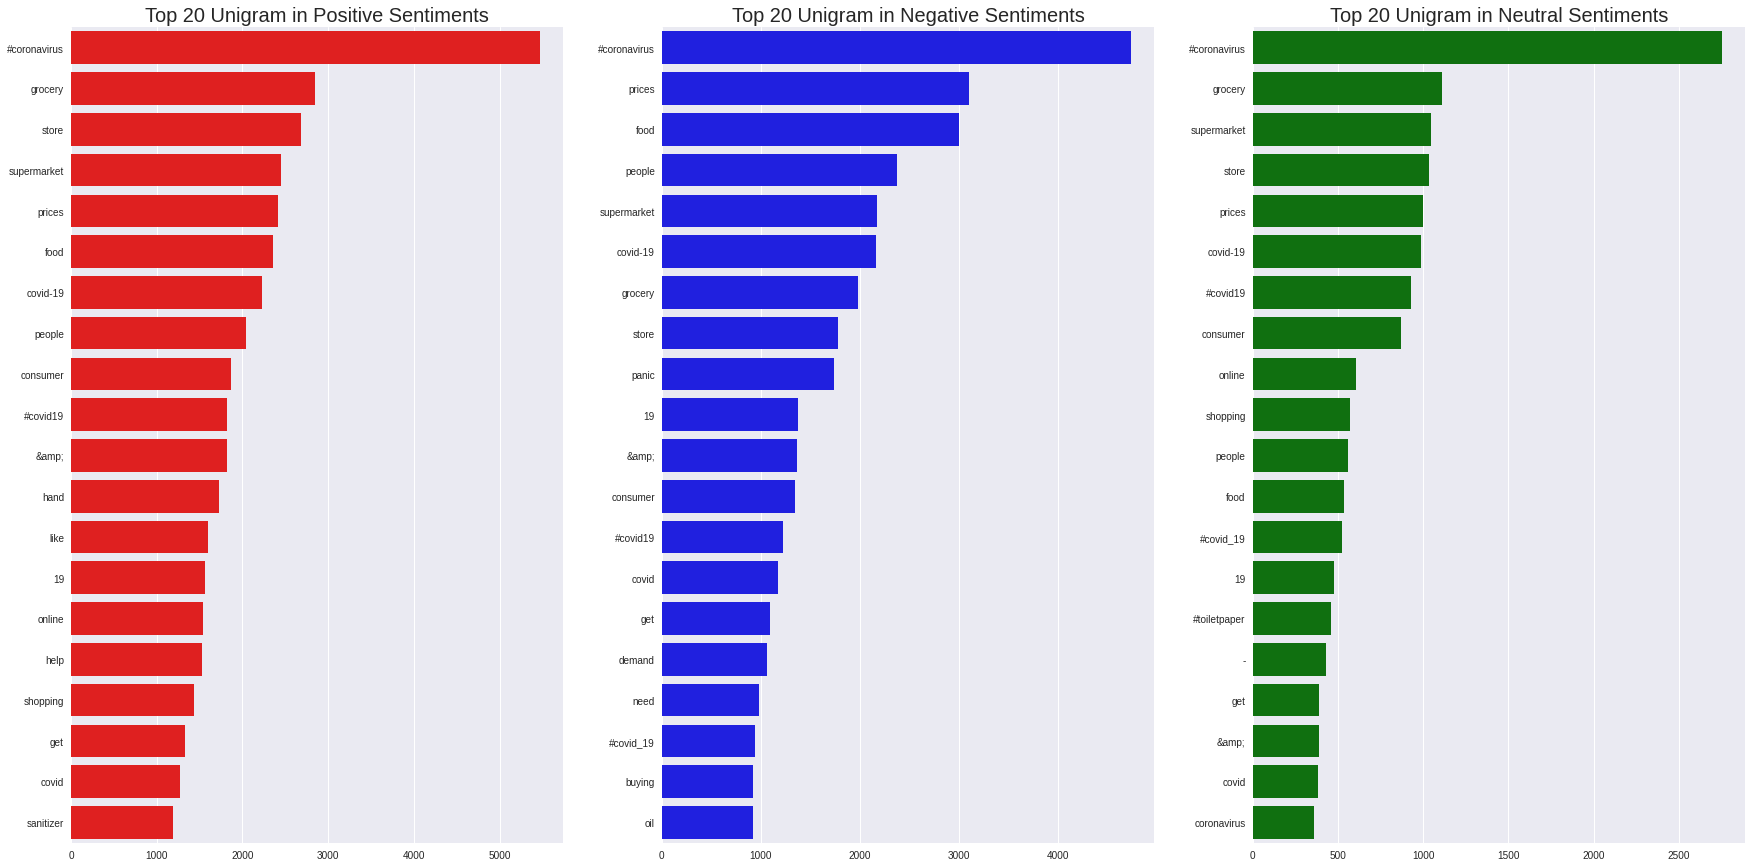

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(30,15))

sns.barplot(y=df_pos_uni[0].values[:N], x=df_pos_uni[1].values[:N], ax=ax[0], color='r')
ax[0].set_title(f'Top {N} Unigram in Positive Sentiments', fontsize=20)

sns.barplot(y=df_neg_uni[0].values[:N], x=df_neg_uni[1].values[:N], ax=ax[1], color='b')
ax[1].set_title(f'Top {N} Unigram in Negative Sentiments', fontsize=20)

sns.barplot(y=df_net_uni[0].values[:N], x=df_net_uni[1].values[:N], ax=ax[2], color='g')
ax[2].set_title(f'Top {N} Unigram in Neutral Sentiments', fontsize=20)

plt.show()

### Bigram

In [ ]:
# Assign an empty dictionary
pos_bi = defaultdict(int)
neg_bi = defaultdict(int)
net_bi = defaultdict(int)

In [ ]:
# Positive Bigram
for t in data_train[pos]['text']:
  for w in n_gram(t, n_gram=2):
    pos_bi[w] += 1

# Negative Bigram
for t in data_train[neg]['text']:
  for w in n_gram(t, n_gram=2):
    neg_bi[w] += 1

# Neutral Bigram
for t in data_train[net]['text']:
  for w in n_gram(t, n_gram=2):
    net_bi[w] += 1

# Creating Dataframes
df_pos_bi = pd.DataFrame(sorted(pos_bi.items(), key=lambda x: x[1])[::-1])
df_neg_bi = pd.DataFrame(sorted(neg_bi.items(), key=lambda x: x[1])[::-1])
df_net_bi = pd.DataFrame(sorted(net_bi.items(), key=lambda x: x[1])[::-1])

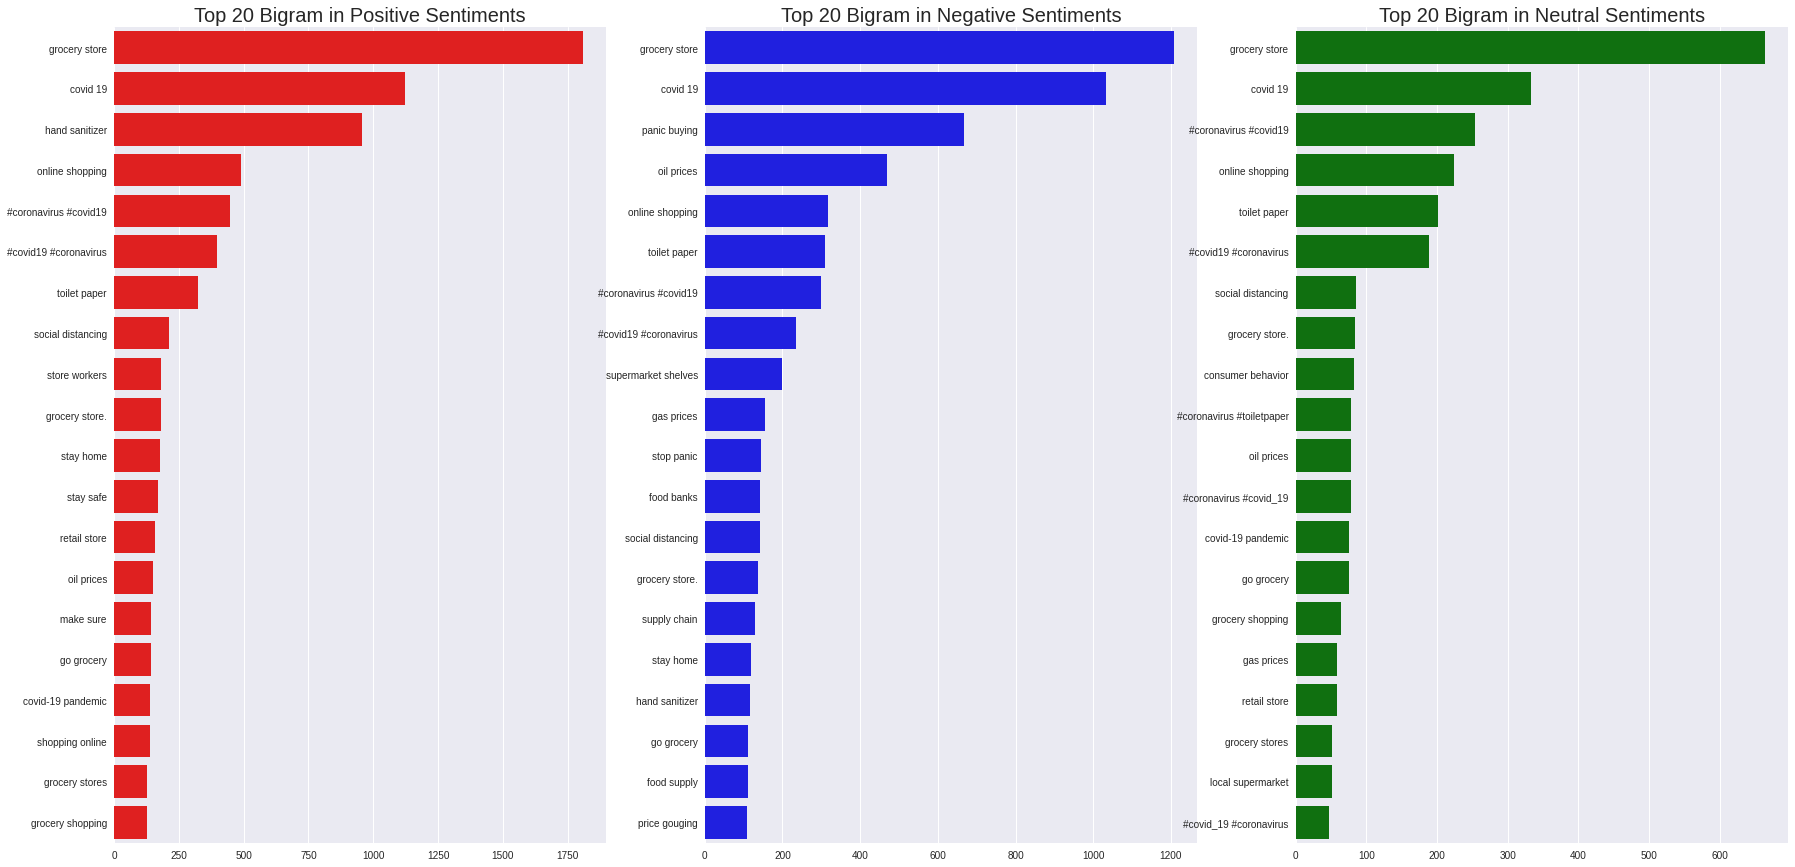

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(30,15))

sns.barplot(y=df_pos_bi[0].values[:N], x=df_pos_bi[1].values[:N], ax=ax[0], color='r')
ax[0].set_title(f'Top {N} Bigram in Positive Sentiments', fontsize=20)

sns.barplot(y=df_neg_bi[0].values[:N], x=df_neg_bi[1].values[:N], ax=ax[1], color='b')
ax[1].set_title(f'Top {N} Bigram in Negative Sentiments', fontsize=20)

sns.barplot(y=df_net_bi[0].values[:N], x=df_net_bi[1].values[:N], ax=ax[2], color='g')
ax[2].set_title(f'Top {N} Bigram in Neutral Sentiments', fontsize=20)

plt.show()

### Trigram

In [ ]:
# Assign an empty dictionary
pos_tri = defaultdict(int)
neg_tri = defaultdict(int)
net_tri = defaultdict(int)

In [ ]:
# Positive Trigram
for t in data_train[pos]['text']:
  for w in n_gram(t, n_gram=3):
    pos_tri[w] += 1

# Negative Trigram
for t in data_train[neg]['text']:
  for w in n_gram(t, n_gram=3):
    neg_tri[w] += 1

# Neutral Trigram
for t in data_train[net]['text']:
  for w in n_gram(t, n_gram=3):
    net_tri[w] += 1

# Creating Dataframes
df_pos_tri = pd.DataFrame(sorted(pos_tri.items(), key=lambda x: x[1])[::-1])
df_neg_tri = pd.DataFrame(sorted(neg_tri.items(), key=lambda x: x[1])[::-1])
df_net_tri = pd.DataFrame(sorted(net_tri.items(), key=lambda x: x[1])[::-1])

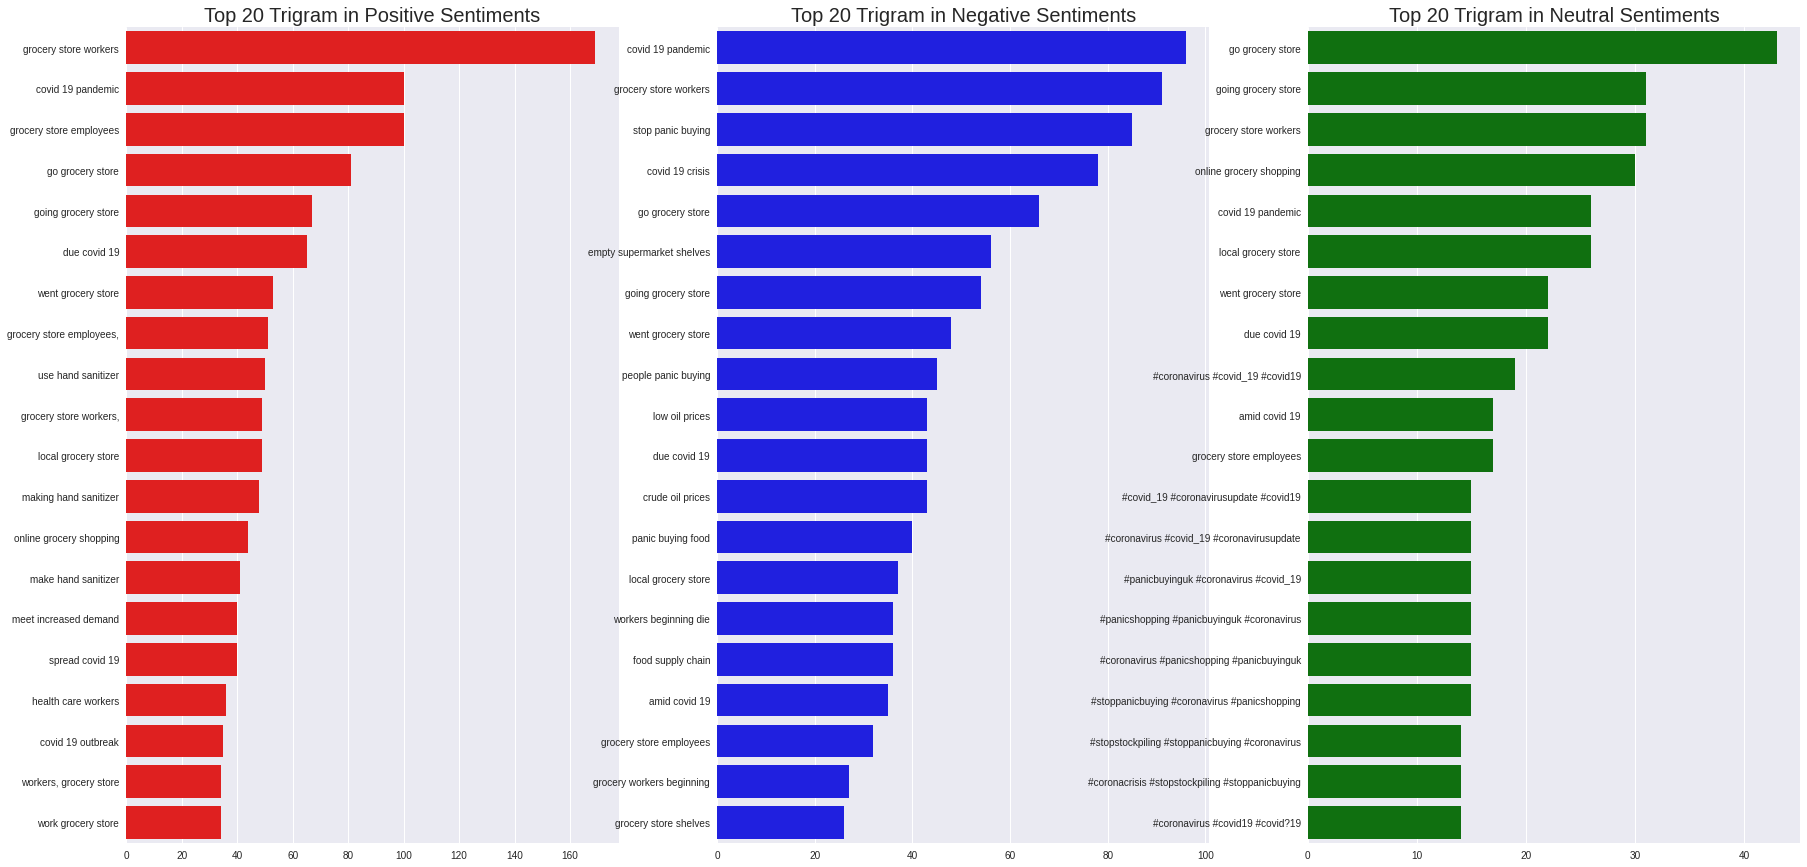

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(30,15))

sns.barplot(y=df_pos_tri[0].values[:N], x=df_pos_tri[1].values[:N], ax=ax[0], color='r')
ax[0].set_title(f'Top {N} Trigram in Positive Sentiments', fontsize=20)

sns.barplot(y=df_neg_tri[0].values[:N], x=df_neg_tri[1].values[:N], ax=ax[1], color='b')
ax[1].set_title(f'Top {N} Trigram in Negative Sentiments', fontsize=20)

sns.barplot(y=df_net_tri[0].values[:N], x=df_net_tri[1].values[:N], ax=ax[2], color='g')
ax[2].set_title(f'Top {N} Trigram in Neutral Sentiments', fontsize=20)

plt.show()